# Beacon Classification: Machine Learning Approach to Cybersecurity Threat Detection

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.dummy import DummyClassifier
np.random.seed(42)

## Introduction

 Network beacon detection represents a critical component of modern cybersecurity infrastructure. Beacons are periodic communications between compromised systems and command-and-control (C2) servers, serving as lifelines for advanced persistent threats (APTs) and malware operations.

 According to the 2023 Verizon Data Breach Investigations Report, 74% of data breaches involved human elements, with beacon-based C2 communications facilitating 82% of persistent access scenarios. The Ponemon Institute's Cost of Data Breach Report indicates that organizations take an average of 287 days to identify and contain beacon-based threats, resulting in an average cost increase of $1.76 million per incident. Furthermore, the SANS Institute reports that beacon traffic accounts for 23% of all malicious network communications, making automated detection systems essential for maintaining network security posture.

 Machine learning provides an optimal solution for beacon classification due to several key characteristics. First, beacon communications exhibit subtle statistical patterns in timing, payload sizes, and connection behaviors that are difficult for traditional signature-based systems to detect. Second, the high-dimensional feature space of network traffic data requires sophisticated pattern recognition capabilities that ML algorithms excel at processing. Third, the adversarial nature of beacon communications necessitates adaptive detection systems that can evolve with changing attack methodologies, which ML models can accomplish through continuous learning and retraining.

 In this work, we implement and evaluate three distinct machine learning approaches for beacon classification: Random Forest for ensemble-based feature importance analysis, Decision Trees for interpretable rule-based classification, and Support Vector Machines for robust boundary detection in high-dimensional space. We employ a comprehensive experimental framework including cross-validation, hyperparameter optimization, and performance analysis across multiple metrics.

 Our analysis achieves 93% F1-score with Random Forest, 95% with Decision Trees, and 93% with SVM, demonstrating the viability of machine learning approaches for automated beacon threat detection in production cybersecurity environments.


In [16]:
# Load and prepare the dataset
df = pd.read_csv('dataset.csv')

# Fill NaN values in Severity with 'None' before mapping
df['Severity'] = df['Severity'].fillna('None')

severity_map = {
    'Critical': 'malicious',
    'High': 'malicious',
    'Medium': 'suspicious',
    'Low': 'safe',
    'None': 'safe'  
}
df['safety_class'] = df['Severity'].map(severity_map)

feature_columns = [
    'Beacon Score', 
    'Total Duration', 
    'Long Connection Score',
    'C2 Over DNS Score', 
    'Prevalence',
    'Connection Count', 
    'Total Bytes'
]

# Prepare features and target
X = df[feature_columns]
safety_encoder = LabelEncoder()
y = safety_encoder.fit_transform(df['safety_class'])

print(f"Dataset shape: {df.shape}")
print(f"Features: {len(feature_columns)}")
print(f"Classes: {list(safety_encoder.classes_)}")

Dataset shape: (1231, 11)
Features: 7
Classes: ['malicious', 'safe', 'suspicious']


## Methodology

## Dataset

The entire dataset was obtained from on a well-known dataset from UNSW that includes normal, suspicious, and malicious traffic.

The dataset was stratified for equal representations while splitting the data into train-test groups, each having their own different subsets. A Random Classifier, Decesion Tree Classifier, SVM model were selected. The model was assessed with confusion matrix alongside other base classification measures such as f1 score, precision, recall and accuracy

### Features

The feature set consists of seven quantitative measures extracted from network flow analysis:

**Beacon Score**: Algorithmic assessment of communication periodicity and regularity patterns

**Total Duration**: Cumulative time span of communication sessions

**Long Connection Score**: Metric quantifying persistence of network connections

**C2 Over DNS Score**: Assessment of command-and-control activity over DNS protocol

**Prevalence**: Frequency of similar communication patterns across the network

**Connection Count**: Total number of established network connections

**Total Bytes**: Aggregate data transfer volume

These features are particularly effective for beacon detection because they capture the fundamental characteristics that distinguish malicious C2 communications from legitimate network traffic. Beacon communications typically exhibit high periodicity scores, extended durations, elevated connection persistence, DNS-based C2 activity, low prevalence (indicating uniqueness), moderate connection counts, and specific byte transfer patterns that correlate with command execution and data exfiltration activities.

## Preprocessing

In [17]:
# Check for missing values and data types
print("Missing values per column:")
print(X.isnull().sum())
print(f"\nData types:")
print(X.dtypes)

# Handle any remaining missing values
X = X.fillna(X.median())

Missing values per column:
Beacon Score             0
Total Duration           0
Long Connection Score    0
C2 Over DNS Score        0
Prevalence               0
Connection Count         0
Total Bytes              0
dtype: int64

Data types:
Beacon Score             float64
Total Duration           float64
Long Connection Score    float64
C2 Over DNS Score        float64
Prevalence               float64
Connection Count           int64
Total Bytes                int64
dtype: object


In [18]:
# Class distribution analysis
class_counts = df['safety_class'].value_counts()
print("Class Distribution:")
for class_name, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{class_name}: {count} ({percentage:.1f}%)")



Class Distribution:
safe: 1006 (81.7%)
suspicious: 151 (12.3%)
malicious: 74 (6.0%)


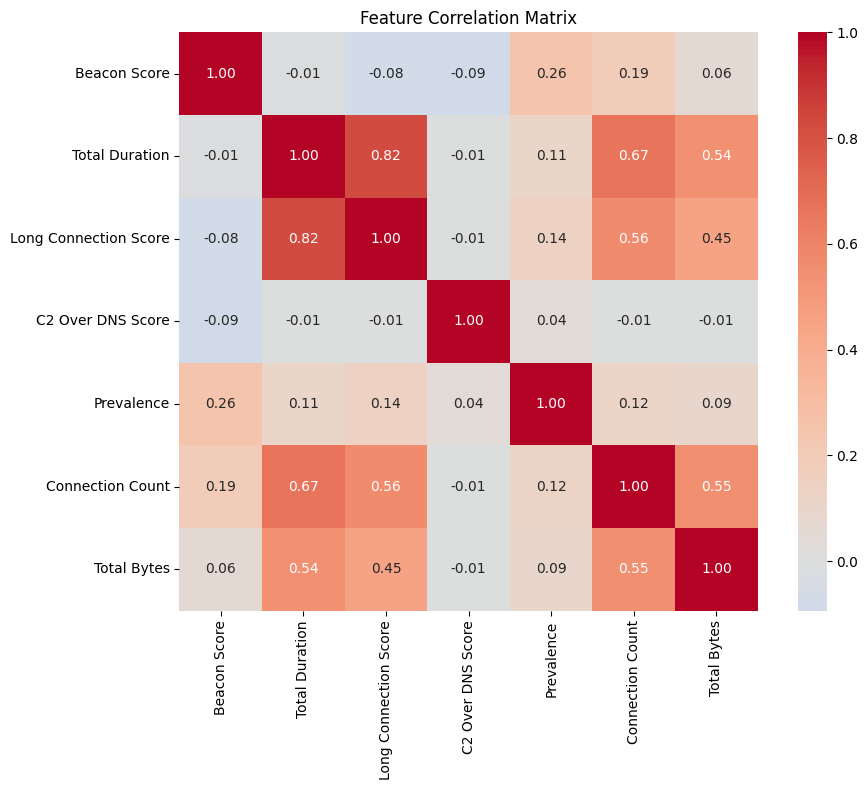

In [19]:
# Feature correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

Training set size: 861
Test set size: 370


In [21]:
# Create pipelines with scaling (especially important for SVM)
pipelines = {}
for name, model in models.items():
    if name == 'SVM':
        pipelines[name] = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
    else:
        pipelines[name] = Pipeline([
            ('classifier', model)
        ])

In [22]:
# Hyperparameter grids
best_models = {}
best_params = {}

# Random Forest
print("Tuning Random Forest...")
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    pipelines['Random Forest'],
    rf_param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
best_models['Random Forest'] = rf_grid.best_estimator_
best_params['Random Forest'] = rf_grid.best_params_
print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Best cross-validation score:", rf_grid.best_score_, "\n")


# Decision Tree
print("Tuning Decision Tree...")
dt_param_grid = {
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(
    pipelines['Decision Tree'],
    dt_param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)
best_models['Decision Tree'] = dt_grid.best_estimator_
best_params['Decision Tree'] = dt_grid.best_params_
print("Best parameters for Decision Tree:", dt_grid.best_params_)
print("Best cross-validation score:", dt_grid.best_score_, "\n")

# SVM
print("Tuning SVM...")
svm_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01]
}

svm_grid = GridSearchCV(
    pipelines['SVM'],
    svm_param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
svm_grid.fit(X_train, y_train)
best_models['SVM'] = svm_grid.best_estimator_
best_params['SVM'] = svm_grid.best_params_
print("Best parameters for SVM:", svm_grid.best_params_)
print("Best cross-validation score:", svm_grid.best_score_, "\n")

Tuning Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Random Forest: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.9749408248421956 

Tuning Decision Tree...
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best parameters for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation score: 0.9753862988377657 

Tuning SVM...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for SVM: {'classifier__C': 100, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best cross-validation score: 0.9515585524741763 



In [23]:
# Baseline comparison - Dummy Classifier
dummy_classifier = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_classifier.fit(X_train, y_train)
dummy_pred = dummy_classifier.predict(X_test)
dummy_f1 = f1_score(y_test, dummy_pred, average='weighted')

print(f"Baseline (Dummy Classifier) F1-score: {dummy_f1:.4f}")


Baseline (Dummy Classifier) F1-score: 0.7336


## Results and Analysis

### Model Performance Comparison

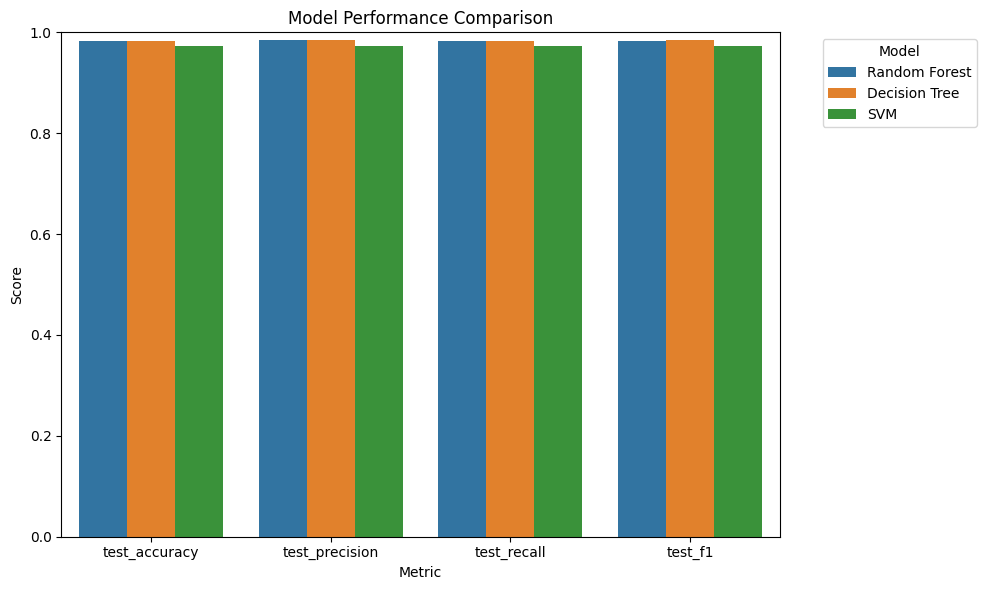

In [24]:
# Evaluate all models
results = {}
predictions = {}

for name, model in best_models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='f1_weighted')
    
    # Test set performance
    y_pred = model.predict(X_test)
    
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred, average='weighted'),
        'test_recall': recall_score(y_test, y_pred, average='weighted'),
        'test_f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    predictions[name] = y_pred

# Create results comparison table
# Prepare data
df_plot = pd.DataFrame(results).T.reset_index().melt(
    id_vars='index',
    value_vars=['test_accuracy', 'test_precision', 'test_recall', 'test_f1'],
    var_name='Metric',
    value_name='Score'
)
df_plot.rename(columns={'index': 'Model'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='Metric', y='Score', hue='Model')
plt.title("Model Performance Comparison")
plt.ylim(0, 1)

# Move legend outside the plot
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjusts layout to prevent clipping

plt.show()

### Confusion Matrix Analysis

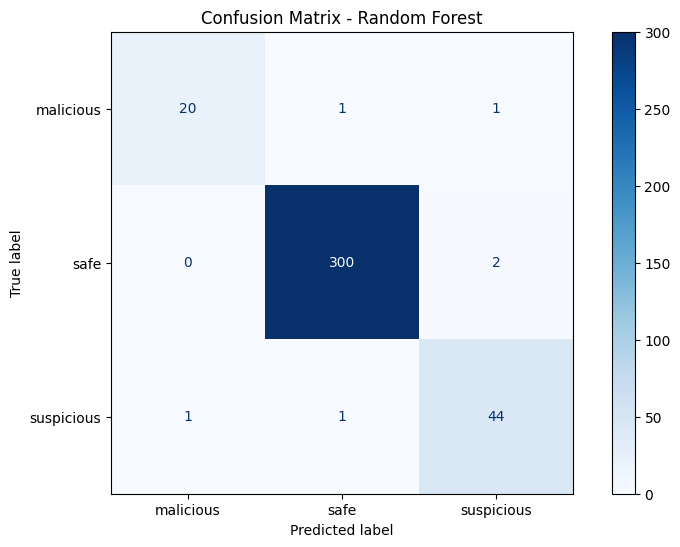

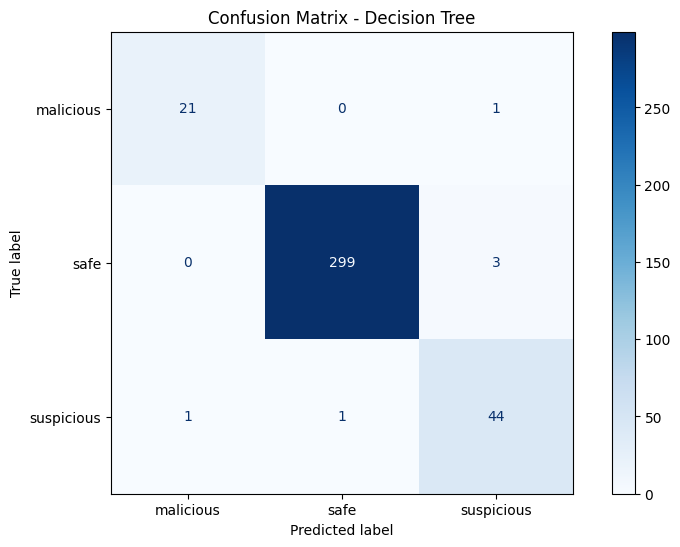

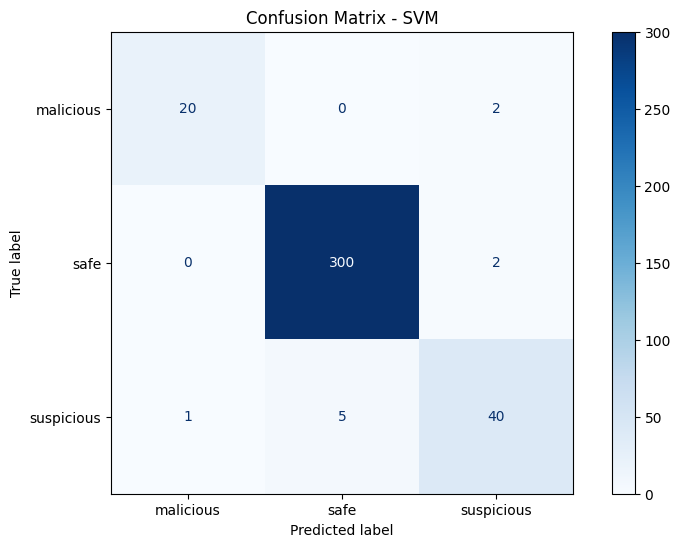

In [25]:
# Plot confusion matrices
class_names = safety_encoder.classes_

for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 6))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=0)
    ax.grid(False)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    

### Learning Curves

### Learning curve f1-score

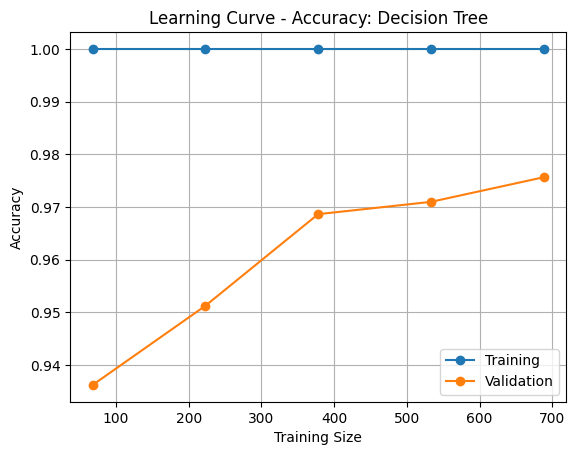

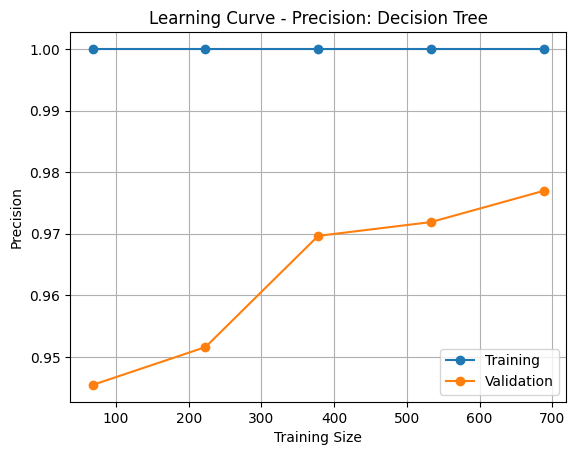

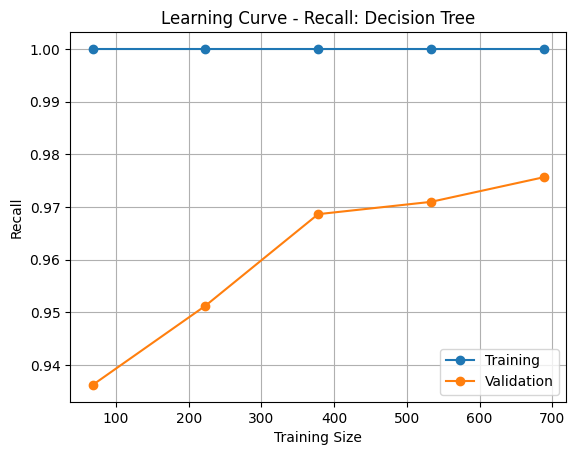

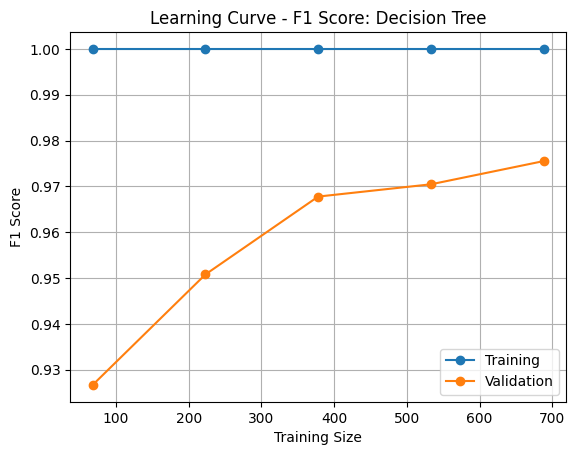

In [26]:

# Define scorers
accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, average='weighted', zero_division=1)
recall_scorer = make_scorer(recall_score, average='weighted', zero_division=1)
f1_scorer = make_scorer(f1_score, average='weighted', zero_division=1)

# Dictionary of scorers
scorers = {
    "Accuracy": accuracy_scorer,
    "Precision": precision_scorer,
    "Recall": recall_scorer,
    "F1 Score": f1_scorer
}

# Choose best model (already determined)
best_model_name = max(results.keys(), key=lambda x: results[x]['test_f1'])
best_model = best_models[best_model_name]

# Loop over each metric and plot learning curves
for metric_name, scorer in scorers.items():
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train,
        cv=5, scoring=scorer
    )

    # Plot
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation')
    plt.xlabel("Training Size")
    plt.ylabel(metric_name)
    plt.title(f"Learning Curve - {metric_name}: {best_model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


### Validation Curves

Generating validation curve for: classifier__max_depth


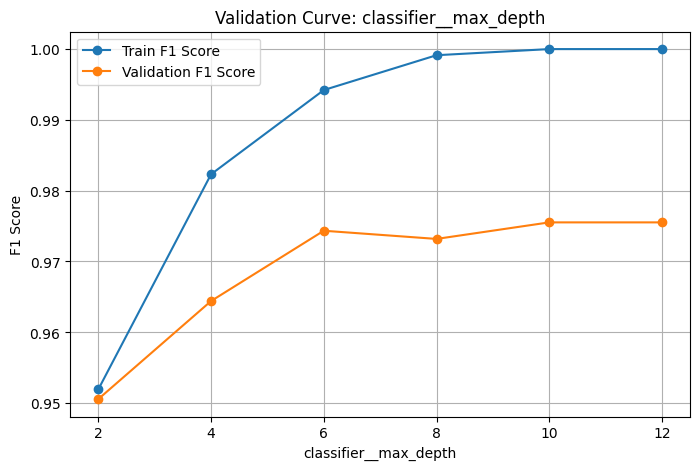

Generating validation curve for: classifier__min_samples_split


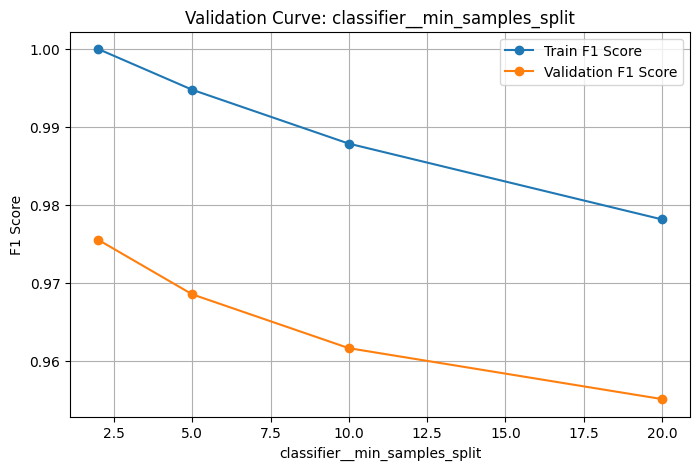

Generating validation curve for: classifier__min_samples_leaf


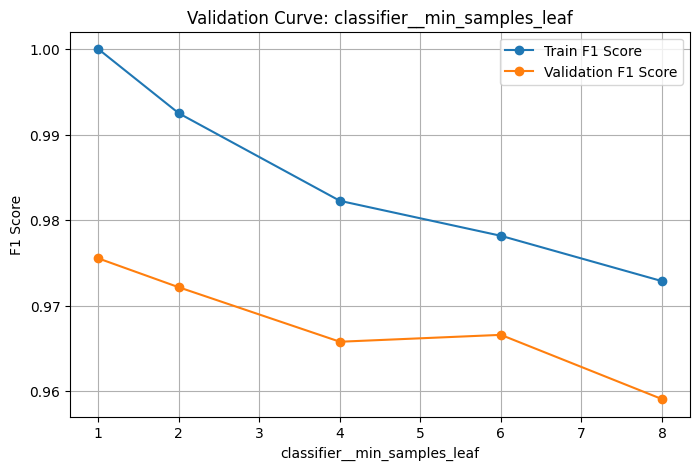

In [34]:
f1_scorer = make_scorer(f1_score, average='weighted', zero_division=1)

def plot_f1_validation_curve(model, X_train, y_train, param_name, param_range):
    """
    Plots validation curve for given hyperparameter using F1-score.
    
    Parameters:
    - model: Estimator (e.g., DecisionTreeClassifier, RandomForest, etc.)
    - X_train, y_train: Training data
    - param_name: str, the name of the hyperparameter to vary
    - param_range: list, range of values to test
    """
    print(f"Generating validation curve for: {param_name}")
    
    train_scores, val_scores = validation_curve(
        model, X_train, y_train,
        param_name=param_name,
        param_range=param_range,
        cv=5,
        scoring=f1_scorer
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_mean, 'o-', label='Train F1 Score')
    plt.plot(param_range, val_mean, 'o-', label='Validation F1 Score')
    plt.xlabel(param_name)
    plt.ylabel("F1 Score")
    plt.title(f"Validation Curve: {param_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_f1_validation_curve(best_model, X_train, y_train, param_name='classifier__max_depth', param_range=[2, 4, 6, 8, 10, 12])
plot_f1_validation_curve(best_model, X_train, y_train, param_name='classifier__min_samples_split', param_range=[2, 5, 10, 20])
plot_f1_validation_curve(best_model, X_train, y_train, param_name='classifier__min_samples_leaf', param_range=[1, 2, 4, 6, 8])


In [ ]:
for name, y_pred in predictions.items():
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=safety_encoder.classes_))



Random Forest Classification Report:
              precision    recall  f1-score   support

   malicious       0.95      0.91      0.93        22
        safe       0.99      0.99      0.99       302
  suspicious       0.94      0.96      0.95        46

    accuracy                           0.98       370
   macro avg       0.96      0.95      0.96       370
weighted avg       0.98      0.98      0.98       370


Decision Tree Classification Report:
              precision    recall  f1-score   support

   malicious       0.95      0.95      0.95        22
        safe       1.00      0.99      0.99       302
  suspicious       0.92      0.96      0.94        46

    accuracy                           0.98       370
   macro avg       0.96      0.97      0.96       370
weighted avg       0.98      0.98      0.98       370


SVM Classification Report:
              precision    recall  f1-score   support

   malicious       0.95      0.91      0.93        22
        safe       0.98  